
Task: (x, y) -> (phi) -> (x', y')

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
%matplotlib inline
sns.set_theme(style="whitegrid")

- Xavier initilization (to initialize the weights)
- Adam optimizer
- MSE Loss

#### Data

In [3]:
# x^2 + y^2 = 1

n = 300 # number of samples
x = [random.uniform(-1, 1) for i in range(n)] # x coord
sgn_lst = [-1, 1]

sgn = []
for i in range(n):
    ind = random.randint(0, len(sgn_lst)-1)
    sgn.append(sgn_lst[ind])
    
y = [sgn[i] * (1 - x[i] ** 2) ** 0.5 for i in range(n)]

data = []
for xi, yi in zip(x, y):
    data.append([xi, yi])
    
data = np.array(data)

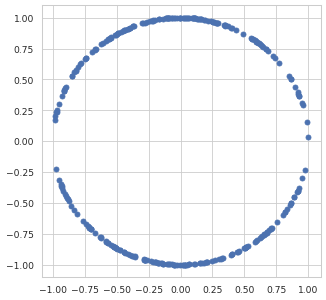

In [4]:
plt.figure(figsize=(6, 6), dpi=60)
plt.scatter(data[:,0], data[:,1])

#### Activatation functions

In [5]:
def tanh(z):
    return 2 / (1 + np.exp(-2 * z)) - 1

def tanh_backward(z):
    return (1 - tanh(z) ** 2) + 1e-12

def relu(z):
    return z * (z > 0)

def relu_backward(z):
    return (z > 0) + 1e-12

#### Architecture

In [6]:
layers = [
    # activation, shape:(out,in)
    {"act":relu, "shape":(20, 2)},
    {"act":relu, "shape":(4, 20)},
    {"act":relu, "shape":(1, 4)},
    {"act":relu, "shape":(4, 1)},
    {"act":relu, "shape":(20, 4)},
    {"act":tanh, "shape":(2, 20)}
]

epochs = 300

In [7]:
# Adam updates
def adam(m, v, z, dz, i, t):
    lr, beta1, beta2 = 0.002, 0.9, 0.999
            
    # moving averages (with parameters beta1 and beta2)
    m[i] = beta1 * m[i] + (1 - beta1) * dz[i]
    v[i] = beta2 * v[i] + (1 - beta2) * dz[i]**2
            
    # bias correction of the moving averages
    m_hat = m[i] / (1. - beta1**t)
    v_hat = v[i] / (1. - beta2**t) 
            
    # update the parameters (weights and biases)
    z[i] -= lr * m_hat / (v_hat**0.5 + 1e-12)
            
    return z[i]

In [8]:
def nn_train(architecture, epochs, train, val):
    
    # global properties
    l, errors = len(architecture), []
    # adam properties
    vw, mw, vb, mb = {},{},{},{}
    # layer properties
    a, w, b, f, = {}, {}, {}, {}

    for i, layer in zip(range(1, l+1), layers):
        n_out, n_in = layer["shape"]
        f[i] = layer["act"]
        
        # Xavier Initialization of weights
        w[i] = np.random.randn(n_out, n_in) / n_in**0.5
        b[i], vb[i], mb[i] = [np.zeros((n_out,1)) for i in [1,2,3]]
        vw[i], mw[i] = [np.zeros((n_out, n_in)) for i in [1,2]]
    
    for t in tqdm(range(1, epochs+1)):
    
        # Train
        for batch in np.split(data, 30):
        
            # Forward propagation
            a[0] = batch.T
            for i in range(1, l + 1):
                a[i] = f[i](np.dot(w[i], a[i-1]) + b[i])
        
            # Backward propagation
            dz, dw, db = {}, {}, {}
            for i in range(1, l+1)[::-1]:
                func = eval(f[i].__name__ + '_backward')
                da = np.dot(w[i+1].T, dz[i+1]) if l-i else 0.5*(a[l] - a[0])
                dz[i] = da * func(a[i])
                dw[i] = np.dot(dz[i], a[i-1].T)
                db[i] = np.sum(dz[i], 1, keepdims=True)
           
            # Adam optimization
            for i in range(1,l+1):
                # weights update
                w[i] = adam(mw, vw, w, dw, i, t)
                # biases update
                b[i] = adam(mb, vb, b, db, i, t)
            
        # Validate, MSE
        a[0] = val.T
        for i in range(1,l+1):
            a[i] = f[i](np.dot(w[i], a[i-1]) + b[i])
        errors += [np.mean((a[l]-a[0])**2)]
    #     print("Val loss - ", errors[-1])
    
    return errors, w, b

### Training on clean data

In [9]:
# splitting of the sample into training, validation and test
train, val, test = np.split(data, [int(.7*len(data)), int(.85*len(data))]) 

In [10]:
errors, weights, bias = nn_train(layers, epochs, train, val)

100%|████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.91it/s]


Text(0.5, 1.0, 'Loss')

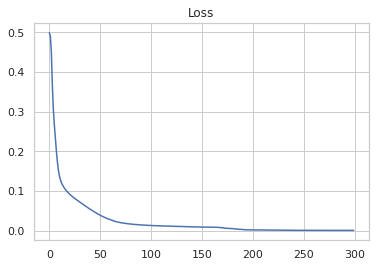

In [11]:
idx = [i for i in range(len(errors))]
plt.plot(idx, errors)
plt.title("Loss")

In [12]:
pred = []
a, f = {}, {}
a[0] = test.T
l = len(layers)
for i, layer in zip(range(1, l+1), layers):
    f[i] = layer["act"]
#forward pass
for i in range(1,len(layers)+1):
    a[i] = f[i](np.dot(weights[i], a[i-1]) + bias[i])
pred_= a[l]

In [13]:
data_ = []
for xi, yi in zip(pred_[0], pred_[1]):
    data_.append([xi, yi])
data_  = np.array(data_)

In [14]:
for i in range(len(test)):
    print(f'({round(a[0][0][i], 4)}, {round(a[0][1][i], 4)}) ==> {round(a[3][0][i], 4)}'\
          f'==> ({round(a[6][0][i], 4)}, {round(a[6][1][i], 4)})')

(-0.4105, 0.9118) ==> 0.1609==> (-0.4229, 0.9233)
(-0.0441, 0.999) ==> 0.2283==> (-0.0434, 0.9734)
(-0.0999, 0.995) ==> 0.2195==> (-0.0963, 0.9694)
(0.4966, -0.868) ==> 1.0586==> (0.5146, -0.8943)
(-0.6677, 0.7444) ==> 0.0893==> (-0.7085, 0.7761)
(-0.9162, -0.4006) ==> 2.5046==> (-0.8719, -0.4093)
(0.8636, 0.5042) ==> 0.5341==> (0.8518, 0.4648)
(-0.8092, -0.5875) ==> 2.341==> (-0.8205, -0.5874)
(0.3516, 0.9361) ==> 0.327==> (0.3629, 0.9427)
(-0.0079, -1.0) ==> 1.2981==> (0.0128, -0.9755)
(-0.9318, -0.363) ==> 2.5202==> (-0.876, -0.3901)
(-0.4463, -0.8949) ==> 1.7321==> (-0.4445, -0.9159)
(0.8673, -0.4978) ==> 0.7813==> (0.8408, -0.4976)
(-0.8946, -0.4469) ==> 2.4781==> (-0.8646, -0.4411)
(-0.0706, -0.9975) ==> 1.333==> (-0.0318, -0.973)
(-0.1767, -0.9843) ==> 1.4336==> (-0.1432, -0.964)
(0.4019, -0.9157) ==> 1.1094==> (0.4218, -0.9228)
(-0.3685, 0.9296) ==> 0.1717==> (-0.3676, 0.9352)
(0.023, -0.9997) ==> 1.288==> (0.0316, -0.9749)
(0.0936, 0.9956) ==> 0.251==> (0.0968, 0.974)
(0.2035,

In [15]:
# model performance, MSE
MSE = [np.mean((a[l]-a[0])**2)]
print(f'MSE, clean data: {MSE}')

MSE, clean data: [0.0008127457613024423]


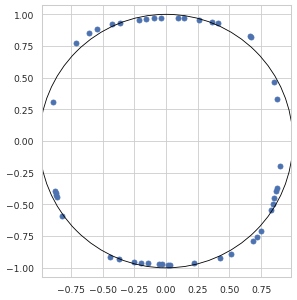

In [16]:
figure, axes = plt.subplots(figsize=(6, 6), dpi=60)
plt.scatter(list(data_[:, 0]), list(data_[:, 1]))
c = plt.Circle( (0, 0 ), 1 , fill = False, color='black')
axes.set_aspect(1)
axes.add_artist(c)
plt.show()

In [17]:
# training on noisy data
noise = np.random.normal(0, .1, data.shape)
data_noise = data + noise

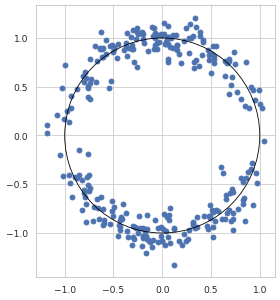

In [18]:
figure, axes = plt.subplots(figsize=(6, 6), dpi=60)
plt.scatter(data_noise[:,0], data_noise[:,1])
c = plt.Circle( (0, 0 ), 1 , fill = False, color = 'black')
axes.set_aspect(1)
axes.add_artist(c)
plt.show()

In [19]:
# разделение выборки на тренировочную, валидационнцю и тестовую
train_noisy, val_noisy, test_noisy = np.split(data_noise, [int(.7*len(data_noise)), int(.85*len(data))]) 

In [20]:
errors_noisy, weights_noisy, bias_noisy = nn_train(layers, epochs, train_noisy, val_noisy)

100%|████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.30it/s]


Text(0.5, 1.0, 'Loss noisy')

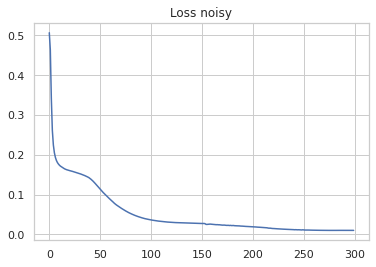

In [21]:
idx = [i for i in range(len(errors_noisy))]
plt.plot(idx, errors_noisy)
plt.title("Loss noisy")

In [22]:
pred_noisy = []
a_noisy, f = {}, {}
a_noisy[0] = test_noisy.T
for i, layer in zip(range(1,len(layers)+1), layers):
    f[i] = layer["act"]
#forward pass
for i in range(1,len(layers)+1):
    a_noisy[i] = f[i](np.dot(weights_noisy[i], a_noisy[i-1]) + bias_noisy[i])
pred_noisy = a_noisy[l]

In [23]:
data_noisy_ = []
for xi, yi in zip(pred_noisy[0], pred_noisy[1]):
    data_noisy_.append([xi, yi])
data_noisy_ = np.array(data_noisy_)

In [24]:
for i in range(len(test_noisy)):
    print(f'({round(a_noisy[0][0][i], 4)}, {round(a_noisy[0][1][i], 4)}) ==> {round(a_noisy[3][0][i], 4)}'\
          f'==> ({round(a_noisy[6][0][i], 4)}, {round(a_noisy[6][1][i], 4)})')

(-0.2853, 0.7585) ==> 0.8297==> (-0.623, 0.836)
(0.0159, 1.1496) ==> 1.2417==> (0.176, 0.9431)
(0.2732, 1.0031) ==> 1.2982==> (0.2954, 0.9294)
(0.4651, -0.961) ==> 0.1346==> (0.4607, -0.9053)
(-0.6726, 0.7595) ==> 0.8131==> (-0.6708, 0.8001)
(-1.0182, -0.417) ==> 0.6187==> (-0.8819, -0.2064)
(0.7634, 0.4458) ==> 1.6559==> (0.8023, 0.7406)
(-0.7448, -0.5421) ==> 0.5239==> (-0.7891, -0.5999)
(0.4225, 0.9772) ==> 1.4045==> (0.4948, 0.8948)
(-0.004, -1.0799) ==> 0.2102==> (0.0073, -0.9723)
(-0.8571, -0.4011) ==> 0.5671==> (-0.8375, -0.4402)
(-0.3567, -0.9764) ==> 0.3108==> (-0.3449, -0.9447)
(0.7169, -0.5476) ==> 0.0478==> (0.7861, -0.6498)
(-0.93, -0.6259) ==> 0.5801==> (-0.8499, -0.3855)
(0.1704, -1.0825) ==> 0.1871==> (0.1558, -0.9596)
(-0.2879, -1.0602) ==> 0.2755==> (-0.2373, -0.9611)
(0.3536, -0.9374) ==> 0.1579==> (0.3338, -0.9348)
(-0.2616, 0.6994) ==> 0.8061==> (-0.6895, 0.7829)
(0.0046, -0.9638) ==> 0.2177==> (-0.0412, -0.9756)
(0.0664, 1.0099) ==> 1.1925==> (0.0676, 0.9528)
(0.2

In [25]:
MSE_noisy = [np.mean((a_noisy[l]-a_noisy[0])**2)]
print(f'MSE, noisy data: {MSE_noisy}')

MSE, noisy data: [0.013837723205978944]


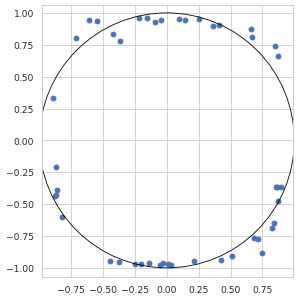

In [26]:
figure, axes = plt.subplots(figsize=(6, 6), dpi=60)
plt.scatter(list(data_[:, 0]), list(data_noisy_[:, 1]))
c = plt.Circle( (0, 0 ), 1 , fill = False, color='black')
axes.set_aspect(1)
axes.add_artist(c)
plt.show()